In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks import *

In [3]:
torch.cuda.is_available()

True

In [4]:
tfms = get_transforms(do_flip=True,flip_vert=False,max_rotate=10.0,max_zoom=1.1,max_lighting=0.2,max_warp=0.2,p_affine=0.75,p_lighting=0.75)


In [5]:
np.random.seed(42)


In [6]:
# from pathlib import Path
# path = Path("train/")

# print(path)
# for c in data.classes:
#     print(c)
#     verify_images(path/c, delete=True)

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=1.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [8]:
loss_func = FocalLoss(gamma=2.)

In [9]:
src = (ImageList.from_folder(path='train').split_by_rand_pct(0.2).label_from_folder())

In [10]:
src

LabelLists;

Train: LabelList (65934 items)
x: ImageList
Image (3, 500, 375),Image (3, 500, 375),Image (3, 500, 375),Image (3, 500, 375),Image (3, 375, 500)
y: CategoryList
class-1059,class-1059,class-1059,class-1059,class-1059
Path: train;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 533, 800),Image (3, 375, 500),Image (3, 2000, 1500),Image (3, 480, 358),Image (3, 500, 375)
y: CategoryList
class-448,class-697,class-204,class-540,class-854
Path: train;

Test: None

In [11]:
data = src.transform(tfms,size=256).databunch(bs=24).normalize()

In [12]:
data.c

45

In [13]:
data

ImageDataBunch;

Train: LabelList (65934 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
class-1059,class-1059,class-1059,class-1059,class-1059
Path: train;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
class-448,class-697,class-204,class-540,class-854
Path: train;

Test: None

In [14]:
alpha=0.99
mom=0.9
eps=1e-6
opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)

In [15]:
learn = cnn_learner(data, models.densenet121,pretrained=False, metrics=[error_rate, accuracy, FBeta(beta=1,average='macro')],loss_func = loss_func,opt_func=opt_func,wd=1e-2)

In [16]:
learn.unfreeze()

In [17]:
learn= learn.mixup(alpha=0.2)

In [18]:
learn.bn_wd=False

In [19]:
learn.true_wd=True

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


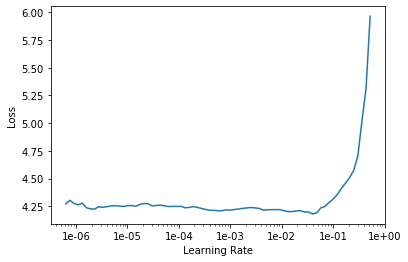

In [21]:
learn.recorder.plot()

In [22]:
lr=7.5e-3

In [23]:
learn.fit_one_cycle(40, lr, div_factor=10, pct_start=0.3)


epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,3.187005,5.659746,0.852515,0.147485,0.016774,21:52
1,2.965927,2.812787,0.804951,0.195049,0.039015,22:09
2,2.876505,2.575158,0.755445,0.244555,0.084957,21:58
3,2.685961,2.438777,0.735000,0.265000,0.112560,21:57
4,2.636441,2.269615,0.699933,0.300067,0.150556,21:38
5,2.560099,2.249651,0.709883,0.290117,0.149180,21:42
6,2.529535,2.311687,0.661409,0.338591,0.185966,21:38
7,2.503853,2.510605,0.663047,0.336953,0.182460,21:30
8,2.506833,3.570051,0.674452,0.325548,0.174150,21:36
9,2.498296,2.920727,0.659649,0.340351,0.192701,21:33


BrokenPipeError: [Errno 32] Broken pipe

In [24]:
learn.save('dn121-with-focal-loss')